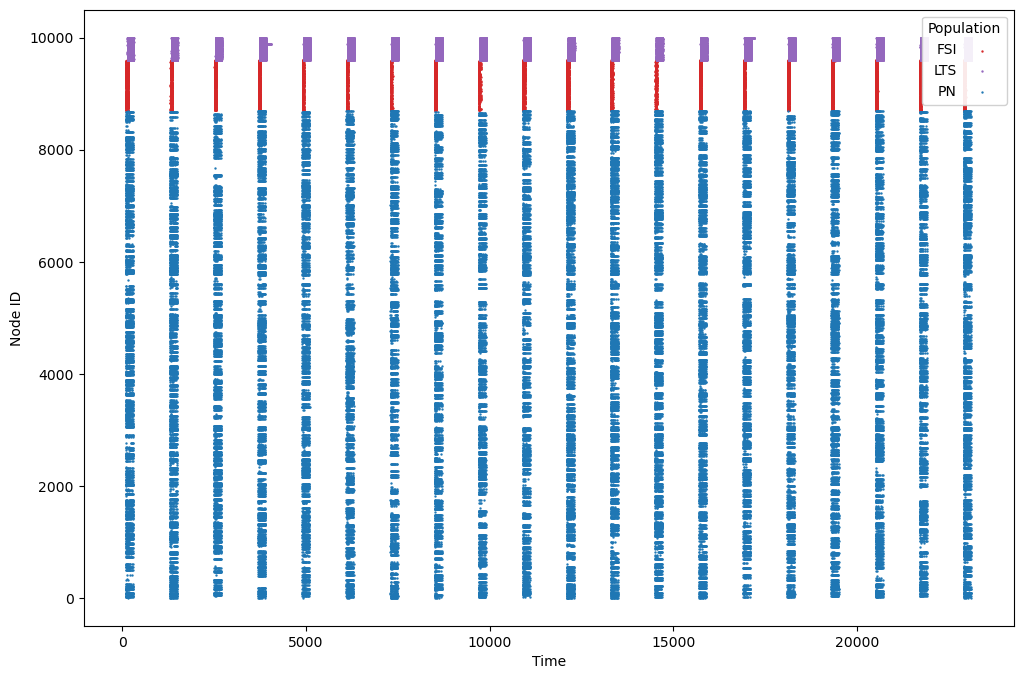

In [ ]:
from bmtool.bmplot import raster
from bmtool.analysis.spikes import load_spikes_to_df
import matplotlib.pyplot as plt
import pandas as pd
#%matplotlib widget

config_path = "../Model-Parameters/simulation_config_stable.json"
_, ax = plt.subplots(1, 1, figsize=(12, 8))
pop_color = {'PN':'tab:blue','FSI':'tab:red','LTS':'tab:purple'}
input_type = "stable"
spikes_df = load_spikes_to_df(f'/home/gjgpb9/OpsinStudy/M1_Slice/Run-Storage/opto_{input_type}/spikes.h5', 'cortex',config=config_path)
raster(spikes_df,config=config_path, network_name='cortex',ax=ax,color_map=pop_color)
plt.show()

In [23]:
pn_spikes = spikes_df[spikes_df['pop_name']=='PN']

total_PNs = 8700
pn_spikes['node_ids'].nunique()

percent_spiked = pn_spikes['node_ids'].nunique()/total_PNs

display(f"Number of unique PN nodes to fire was {pn_spikes['node_ids'].nunique()} which is {percent_spiked:1.3f} of the network")
display(f"Number of PN spikes is {len(pn_spikes['timestamps'])}")

'Number of unique PN nodes to fire was 1447 which is 0.166 of the network'

'Number of PN spikes is 79381'

In [24]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

def get_current_for_gid_and_probe(file_path, target_gid, probe_number):
    """
    Retrieve the current for a specific GID and probe number from the HDF5 file.
    
    Parameters:
    - file_path: Path to the HDF5 file containing the simulation data.
    - target_gid: The GID (Global ID) of the site you want to access.
    - probe_number: The probe number (index) to retrieve the current from (starting from 0).
    
    Returns:
    - A 1D array of the current at the given GID and probe across all time steps.
    """
    with h5py.File(file_path, 'r') as f:
        # Load the relevant datasets
        stim_data = f['/stim/data']  # Shape: (nsteps, total_nsites, nprobes)
        gids = f['/stim/gids']       # Shape: (total_nsites,)

        # Check if the target GID exists in the gids array
        if target_gid not in gids[:]:
            raise ValueError(f"GID {target_gid} not found in the dataset.")

        # Find the index of the target GID in the gids array
        site_idx = (gids[:] == target_gid).nonzero()[0][0]  # Find the index of the GID

        # Ensure the probe_number is valid
        if probe_number >= stim_data.shape[2]:
            raise ValueError(f"Probe number {probe_number} exceeds the number of probes ({stim_data.shape[2]})")

        # Retrieve the current for the given GID and probe number across all time steps
        current = stim_data[:, site_idx, probe_number]  # Shape: (nsteps,)

    return current

output_file = f"../Run-Storage/opto_{input_type}/opto_stim_currents.h5" 
temp = h5py.File(output_file)
display(temp['stim']['gids'][:].shape)
display(temp['stim']['data'].shape)

(1699,)

(240000, 1699, 1)

In [25]:
cell_id1 = pn_spikes['node_ids'].values[0]
cell_id2 = pn_spikes['node_ids'].values[3]

data_for_gid0_probe0 = get_current_for_gid_and_probe(output_file, cell_id1, 0)
data_for_gid1_probe0 = get_current_for_gid_and_probe(output_file, cell_id2, 0)


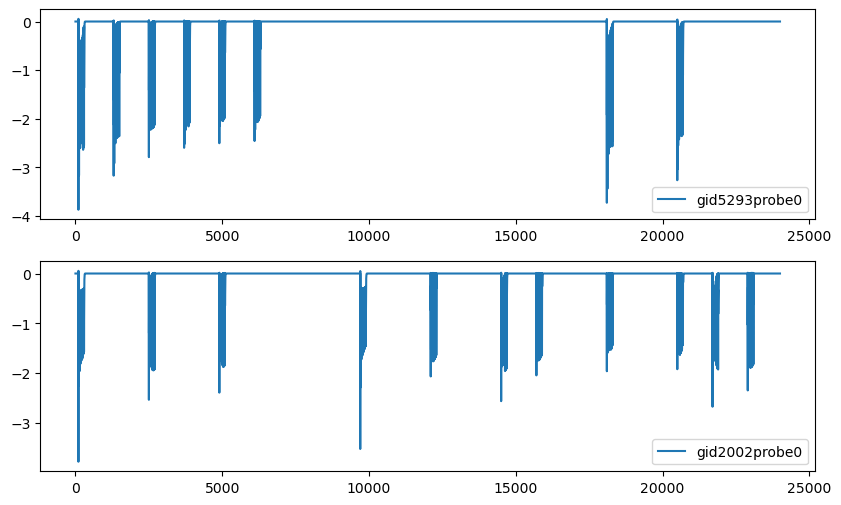

In [26]:
f = h5py.File(f"../Run-Storage/opto_{input_type}/v_traces.h5")

mapping=f['report']['cortex']['mapping']
time = np.arange(mapping['time'][0],mapping['time'][1],mapping['time'][2])

plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)

plt.subplot(2, 1, 1)
plt.plot(time,data_for_gid0_probe0,label=f'gid{cell_id1}probe0')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time,data_for_gid1_probe0,label=f'gid{cell_id2}probe0')

plt.legend()
plt.show()

## Opsin firing in space


In [27]:
df = pd.read_csv("/home/gjgpb9/OpsinStudy/M1_Slice/Model-Parameters/opto_input/combined_checkerboard_spikes_stable.csv")

temp = df[df['checkerboard_number']==0]
start = temp['timestamps'].min()
end = temp['timestamps'].max()

pn_spikes_first_board = pn_spikes[(pn_spikes['timestamps'] >= start) & (pn_spikes['timestamps'] <= end)]

temp = df[df['checkerboard_number']==1]
start = temp['timestamps'].min()
end = temp['timestamps'].max()
pn_spikes_second_board = pn_spikes[(pn_spikes['timestamps'] >= start) & (pn_spikes['timestamps'] <= end)]

In [28]:
set1 = set(pn_spikes_first_board['node_ids'])
set2 = set(pn_spikes_second_board ['node_ids'])

# Find common and unique nodeIDs
common_ids = set1 & set2  # Intersection (IDs in both)
unique_to_df1 = set1 - set2  # IDs only in df1
unique_to_df2 = set2 - set1  # IDs only in df2

# Print results
print(f"Common nodeIDs: {len(common_ids)}")
print(f"Unique to df1: {len(unique_to_df1)}")
print(f"Unique to df2: {len(unique_to_df2)}")

Common nodeIDs: 91
Unique to df1: 291
Unique to df2: 288


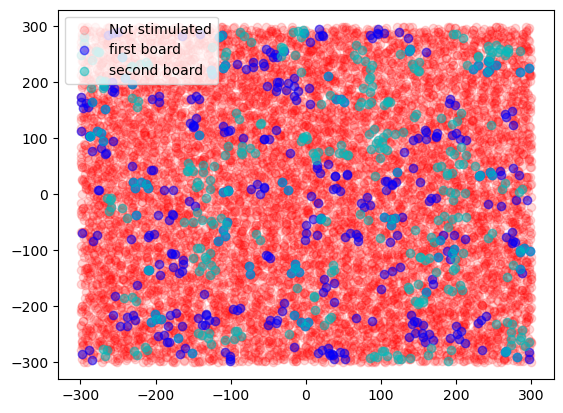

In [29]:
from bmtool.util.util import load_nodes_from_config

nodes = load_nodes_from_config(config_path)
nodes = nodes['cortex']
nodes_that_fired_first_board = nodes[nodes.index.isin(pn_spikes_first_board['node_ids'])]
nodes_that_fired_second_board = nodes[nodes.index.isin(pn_spikes_second_board['node_ids'])]

plt.scatter(nodes['pos_x'],nodes['pos_y'],color='r',alpha=0.15,label='Not stimulated')
plt.scatter(nodes_that_fired_first_board['pos_x'],nodes_that_fired_first_board['pos_y'],color='b',alpha=0.5,label='first board')
plt.scatter(nodes_that_fired_second_board['pos_x'],nodes_that_fired_second_board['pos_y'],color='c',alpha=0.5,label='second board')
plt.legend()
plt.show()

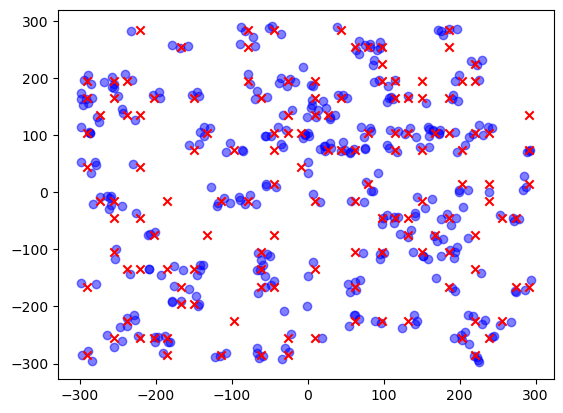

In [30]:
board_number = 5
file = f"scaled_probe_positions_checkerboard{board_number}.csv"
checkboard_path = f"../Model-Parameters/checkerboards/{file}"

# will only really work for stable rn
opsin_df = pd.read_csv("/home/gjgpb9/OpsinStudy/M1_Slice/Model-Parameters/opto_input/combined_checkerboard_spikes_stable.csv")

temp = opsin_df[opsin_df['checkerboard_number']==board_number]
start = temp['timestamps'].min()
end = temp['timestamps'].max()


pn_spikes_stim_on_checkerboard = pn_spikes[(pn_spikes['timestamps'] >= start) & (pn_spikes['timestamps'] <= end)]
nodes_on_checkerboard = nodes[nodes.index.isin(pn_spikes_stim_on_checkerboard['node_ids'])]
plt.scatter(nodes_on_checkerboard['pos_x'],nodes_on_checkerboard['pos_y'],color='b',alpha=0.5)

checkerboard_locations = pd.read_csv(checkboard_path)
plt.scatter(checkerboard_locations['X'],checkerboard_locations['Y'],marker='x',color='r')
plt.show()

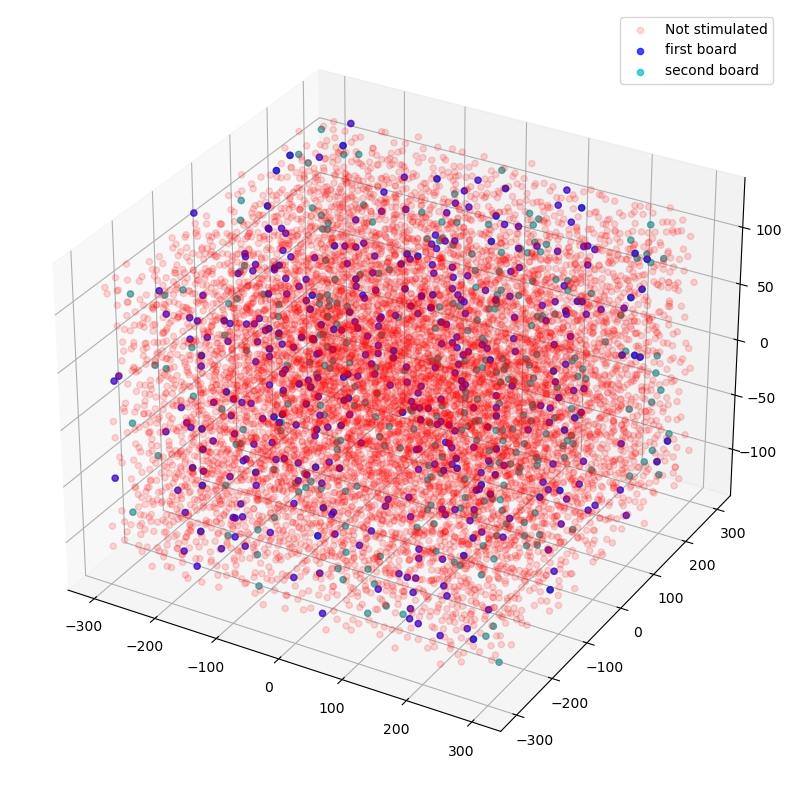

In [31]:
#%matplotlib widget
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(nodes['pos_x'],nodes['pos_y'],nodes['pos_z'],color='r',alpha=0.15,label='Not stimulated')
ax.scatter(nodes_that_fired_first_board['pos_x'],nodes_that_fired_first_board['pos_y'],nodes_that_fired_first_board['pos_z'],
           color='b',alpha=0.7,label='first board')
ax.scatter(nodes_that_fired_second_board['pos_x'],nodes_that_fired_second_board['pos_y'],nodes_that_fired_second_board['pos_z'],
           color='c',alpha=0.7,label='second board')
plt.legend()
plt.show()